# Обучение модели классификации комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.


Задача- обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

## Подготовка

In [ ]:
!{sys.executable} -m pip install spacy
import sys

import spacy
from tqdm.notebook import tqdm

import pandas as pd
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn import svm, datasets

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

/bin/bash: {sys.executable}: command not found


Загрузим полученные данные и считаем их

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
tqdm.pandas()

load_model = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))


def Lematizer_spacy(df, column, list_name):

    for text in tqdm(df[column]):
        cleaned_text = re.sub("[^a-zA-Z]", " ", text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        tokens = word_tokenize(cleaned_text)
        doc = load_model(cleaned_text)
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        result_text = " ".join(filtered_tokens)
        doc = load_model(result_text)
        doc = " ".join([token.lemma_ for token in doc])
        list_name.append(doc)


In [ ]:
new_text = []
Lematizer_spacy(df, 'text', new_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
new_text

['explanation edit make username Hardcore Metallica Fan revert vandalism closure gas vote New York Dolls FAC please remove template talk page since retire',
 'aww match background colour seemingly stick thank talk January UTC',
 'hey man really try edit war guy constantly remove relevant information talk edit instead talk page seem care format actual info',
 'make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg Wikipedia good article nomination transport',
 'sir hero chance remember page',
 'congratulation well use tool well talk',
 'COCKSUCKER pis around work',
 'vandalism Matt Shirvington article revert please ban',
 'sorry word nonsense offensive anyway intending write anything article wow would jump vandalism merely request encycl

Проверим, как алгоритм справился с лематизацией

In [ ]:
df['cleaned_txt'] = new_text
df.head(5)

,text,toxic,cleaned_txt
0,Explanation\nWhy the edits made under my usern...,0,explanation edit make username Hardcore Metall...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stick th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


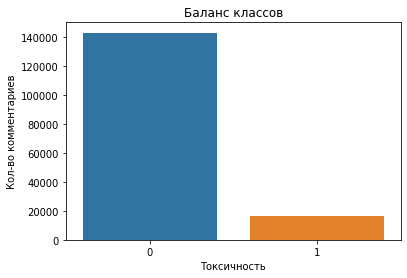

In [ ]:
#Изучим также текущее распределение данных, чтобы понять как они размечены

sns.countplot(data=df, x="toxic")
plt.title("Баланс классов")
plt.xlabel("Токсичность")
plt.ylabel("Кол-во комментариев");

Для выбора оптимальной модели и подбора её гиперпараметров, используем не весь датасет, а только 5000 строк из него. Так как перебор гиперпараметров на полном датасете, в связи с недостатком возможностей облачный сервисов и моего компьютера занимает слишком много времени.

In [ ]:
df_train = df.loc[0:5000]

На лицо, виден дисбаланс классов, поэтому крайне важно будет статифицировать целевой признак при разделение выборок

In [ ]:
#Проведем разделение выборки на тренировочную и тестовую

features_train, features_test, target_train, target_test = train_test_split(
    df_train['cleaned_txt'], df_train['toxic'], test_size=0.1, stratify=df_train['toxic'])

In [ ]:
#from gensim.models import Word2Vec

#sentences = [sentence.split() for sentence in features_train]
#w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)


#def vectorize(sentence):
#    words = sentence.split()
#    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
#    if len(words_vecs) == 0:
#        return np.zeros(100)
#    words_vecs = np.array(words_vecs)
#    return words_vecs.mean(axis=0)

#features_train = np.array([vectorize(sentence) for sentence in features_train])
#features_test = np.array([vectorize(sentence) for sentence in features_test])

Также как видно из кода выше, первично я использовал векторизацию с помощью Word2Vec, но он только понизил метрику, поэтому от него было решено отказаться в угоду Tfidf

## Обучение

Во избежание утечки признаков во время кросс валидации, реализуем TfidfVectorizer отдельно для каждой модели в рамках пайплайна, чтобы TfidfVectorizer не обучался на валидационном пайплайне, вместе с тренировочным.

In [ ]:
#Модель LogisticRegression


lr_classifier = LogisticRegression(random_state=0)

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", lr_classifier)
    ]
)

lr_param_grid = {
    'clf__max_iter': [700],
    'clf__C': range(4, 15 ,2)
}

lr_grid_search = GridSearchCV(estimator=pipeline, param_grid=lr_param_grid, cv=5, scoring='f1')
lr_grid_search.fit(features_train, target_train)

print("LogisticRegression - Лучшие параметры:", lr_grid_search.best_params_)
print("LogisticRegression - Наилучшая оценка:", lr_grid_search.best_score_)

LogisticRegression - Лучшие параметры: {'clf__C': 14, 'clf__max_iter': 700}
LogisticRegression - Наилучшая оценка: 0.5954430560019194


In [ ]:
#Модель DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=0)

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf",  dt_classifier)
    ]
)

dt_param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}
dt_grid_search = GridSearchCV(estimator=pipeline, param_grid=dt_param_grid, cv=5, scoring='f1')
dt_grid_search.fit(features_train, target_train)

# Выведите наилучшие параметры и оценку каждой модели
print("DecisionTreeClassifier - Лучшие параметры:", dt_grid_search.best_params_)
print("DecisionTreeClassifier - Наилучшая оценка:", dt_grid_search.best_score_)

DecisionTreeClassifier - Лучшие параметры: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10}
DecisionTreeClassifier - Наилучшая оценка: 0.6505009495473925


In [ ]:
# Модель CatBoostClassifier
catboost_classifier = CatBoostClassifier(random_state=0, silent= True)

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf",  catboost_classifier)
    ]
)

catboost_param_grid = {
    'clf__depth': [4, 6, 8],
    'clf__learning_rate': [0.01, 0.1, 1],
    'clf__iterations': [100, 500, 1000]
}

catboost_grid_search = GridSearchCV(estimator=pipeline, param_grid=catboost_param_grid, cv=5, scoring='f1')
catboost_grid_search.fit(features_train, target_train)

print("CatBoostClassifier - Лучшие параметры:", catboost_grid_search.best_params_)
print("CatBoostClassifier - Наилучшая оценка:", catboost_grid_search.best_score_)

CatBoostClassifier - Лучшие параметры: {'clf__depth': 6, 'clf__iterations': 1000, 'clf__learning_rate': 0.1}
CatBoostClassifier - Наилучшая оценка: 0.6756659083328217


In [ ]:
#Модель RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=0)

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf",  rf_classifier)
    ]
)

rf_param_grid = {
    'clf__n_estimators': [200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}
rf_grid_search = GridSearchCV(estimator=pipeline, param_grid=rf_param_grid, cv=5, scoring='f1')
rf_grid_search.fit(features_train, target_train)

print("RandomForestClassifier - Лучшие параметры:", rf_grid_search.best_params_)
print("RandomForestClassifier - Наилучшая оценка:", rf_grid_search.best_score_)

RandomForestClassifier - Лучшие параметры: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
RandomForestClassifier - Наилучшая оценка: 0.5921992152062392


In [ ]:
#Модель Support Vector Machine

SVM = svm.SVC(decision_function_shape="ovo")

pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf",  SVM)
    ]
)

scores_list = cross_val_score(estimator=pipeline,
                              X=features_train,
                              y=target_train,
                              cv=5,
                              scoring='f1')

SVM_results = '-', scores_list.mean()
print("SupportVectorMachine - Наилучшая оценка:", SVM_results)

SupportVectorMachine - Наилучшая оценка: 0.4484832135185498


In [ ]:
DecisionTreeClassifier_result = dt_grid_search.best_params_, dt_grid_search.best_score_
LogisticRegression_result = lr_grid_search.best_params_, lr_grid_search.best_score_
CatBoostClassifier_result = catboost_grid_search.best_params_, catboost_grid_search.best_score_
RandomForestClassifier_result = rf_grid_search.best_params_, rf_grid_search.best_score_
SVM_result= SVM_results, '-'

# Выведите наилучшие параметры и оценку каждой модели
print("DecisionTreeClassifier - Лучшие параметры:", dt_grid_search.best_params_)
print("DecisionTreeClassifier - Наилучшая оценка:", dt_grid_search.best_score_)
print("LogisticRegression - Лучшие параметры:", lr_grid_search.best_params_)
print("LogisticRegression - Наилучшая оценка:", lr_grid_search.best_score_)
print("CatBoostClassifier - Лучшие параметры:", catboost_grid_search.best_params_)
print("CatBoostClassifier - Наилучшая оценка:", catboost_grid_search.best_score_)
print("RandomForestClassifier - Лучшие параметры:", rf_grid_search.best_params_)
print("RandomForestClassifier - Наилучшая оценка:", rf_grid_search.best_score_)
print("SupportVectorMachine - Наилучшая оценка:", SVM_results)

DecisionTreeClassifier - Лучшие параметры: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10}
DecisionTreeClassifier - Наилучшая оценка: 0.6505009495473925
LogisticRegression - Лучшие параметры: {'clf__C': 14, 'clf__max_iter': 700}
LogisticRegression - Наилучшая оценка: 0.5954430560019194
CatBoostClassifier - Лучшие параметры: {'clf__depth': 6, 'clf__iterations': 1000, 'clf__learning_rate': 0.1}
CatBoostClassifier - Наилучшая оценка: 0.6756659083328217
RandomForestClassifier - Лучшие параметры: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
RandomForestClassifier - Наилучшая оценка: 0.5921992152062392
SupportVectorMachine - Наилучшая оценка: 0.4484832135185498


In [ ]:
display(pd.DataFrame([DecisionTreeClassifier_result, LogisticRegression_result, CatBoostClassifier_result, RandomForestClassifier_result, SVM_result],
             columns=['Гиперпараметры', 'F1'],
                      index=['DecisionTreeClassifier','LogisticRegression','CatBoostClassifier', 'RandomForestClassifier', 'SupportVectorMachine']))

,Гиперпараметры,F1
DecisionTreeClassifier,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.650501
LogisticRegression,"{'clf__C': 14, 'clf__max_iter': 700}",0.595443
CatBoostClassifier,"{'clf__depth': 6, 'clf__iterations': 1000, 'cl...",0.675666
RandomForestClassifier,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.592199
SupportVectorMachine,0.448483,-


## Выводы

Теперь обучим наилучшую модель с наилучшими выбранными гиперпараметрами на полном датасете для проверки на тестовой выборке

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    df['cleaned_txt'], df['toxic'], test_size=0.1, stratify=df['toxic'])

In [ ]:
count_tf_idf = TfidfVectorizer()

features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

In [ ]:
model = CatBoostClassifier(depth = 6, iterations= 1000, learning_rate= 0.1, random_state=0)

# Обучение модели
model.fit(features_train, target_train)

# Предсказание на тестовом наборе
y_pred = model.predict(features_test)

# Расчет метрики F1
f1 = f1_score(target_test, y_pred)

print(f"Метрика F1: {f1}")

0:	learn: 0.5891592	total: 3.13s	remaining: 52m 11s
1:	learn: 0.5111053	total: 5.5s	remaining: 45m 42s
2:	learn: 0.4484397	total: 7.87s	remaining: 43m 34s
3:	learn: 0.4020784	total: 10.2s	remaining: 42m 27s
4:	learn: 0.3658287	total: 12.5s	remaining: 41m 37s
5:	learn: 0.3374015	total: 14.9s	remaining: 41m 8s
6:	learn: 0.3153338	total: 17.3s	remaining: 40m 47s
7:	learn: 0.2972664	total: 19.6s	remaining: 40m 31s
8:	learn: 0.2824545	total: 22s	remaining: 40m 23s
9:	learn: 0.2711500	total: 24.4s	remaining: 40m 12s
10:	learn: 0.2620722	total: 26.7s	remaining: 40m
11:	learn: 0.2542461	total: 29s	remaining: 39m 43s
12:	learn: 0.2477442	total: 31.3s	remaining: 39m 33s
13:	learn: 0.2425915	total: 33.5s	remaining: 39m 22s
14:	learn: 0.2380712	total: 35.9s	remaining: 39m 17s
15:	learn: 0.2341228	total: 38.3s	remaining: 39m 17s
16:	learn: 0.2300092	total: 40.8s	remaining: 39m 17s
17:	learn: 0.2271549	total: 43s	remaining: 39m 5s
18:	learn: 0.2244799	total: 45.3s	remaining: 39m
19:	learn: 0.2219698

**Вывод:**

- Наилучший результат на тестовом датасете показала модель- CatBoostClassifier - 0.77
- Основной прирост к метрике дала именно перебор гиперпарматров, в то время как использование различных подходов к векторизации, не показал значительных результатов в рамках данного датасета, однако это также могло быть связано с использванием не самых оптимальных алгоритмов векторизации, что определенно стоит изучить в будущем
- Что интересно, из-за большого датасета, перебор гиперпараметров на полном датасете был слишком время затратен, в связи с чем, я проводил перебор гиперпараметров только на 5000 строках датасета, после чего проводил обучение лучшей модели на полном датасете и предсказание на тестовой выборке. Что позволило мне получить мне в итоге оптимальный необходимый по условиям задачи результат, с учетом ограниченных мощностей